# **Stable Diffusion** 🎨
*...using `🧨diffusers`*

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

This Colab notebook shows how to use Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

Let's get started!

## 1. How to use `StableDiffusionPipeline`

Before diving into the theoretical aspects of how Stable Diffusion functions,
let's try it out a bit 🤗.

In this section, we show how you can run text to image inference in just a few lines of code!

### Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [3]:
import torch

In [4]:
if torch.cuda.is_available():
    !nvidia-smi

Fri May 30 08:01:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [5]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

  Using cached diffusers-0.11.1-py3-none-any.whl.metadata (29 kB)
Using cached diffusers-0.11.1-py3-none-any.whl (524 kB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.31.0
    Uninstalling diffusers-0.31.0:
      Successfully uninstalled diffusers-0.31.0


### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.

We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [6]:
# This is added to get around some issues of Torch not loading models correctly (test on Mac OS X and Kubuntu Linux)
!pip install --upgrade huggingface-hub==0.26.2 transformers==4.46.1 tokenizers==0.20.1 diffusers==0.31.0

  Using cached diffusers-0.31.0-py3-none-any.whl.metadata (18 kB)
Using cached diffusers-0.31.0-py3-none-any.whl (2.9 MB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.11.1
    Uninstalling diffusers-0.11.1:
      Successfully uninstalled diffusers-0.11.1


In [7]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Next, let's move the pipeline to GPU to have faster inference.

In [8]:
if torch.cuda.is_available():
    device=torch.device("cuda")
elif torch.backends.mps.is_available():
    device=torch.device("mps")

pipe = pipe.to(device)

And we are ready to generate images:

  0%|          | 0/50 [00:00<?, ?it/s]

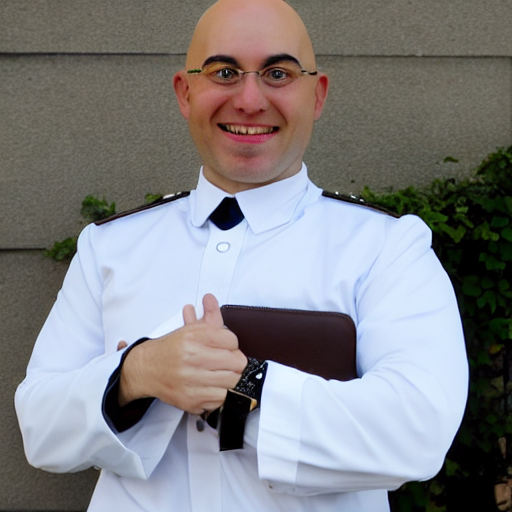

In [25]:
prompt = "a bald man in white uniform with brown briefcase"
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
image.save(f"uniform.png")

# or if you're in a google colab you can directly display it with
image

  0%|          | 0/50 [00:00<?, ?it/s]

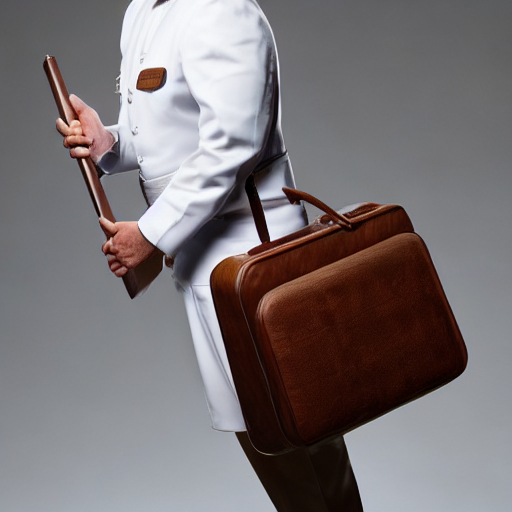

In [26]:
generator = torch.Generator(device).manual_seed(1024)

image = pipe(prompt, generator=generator).images[0]

image

  0%|          | 0/15 [00:00<?, ?it/s]

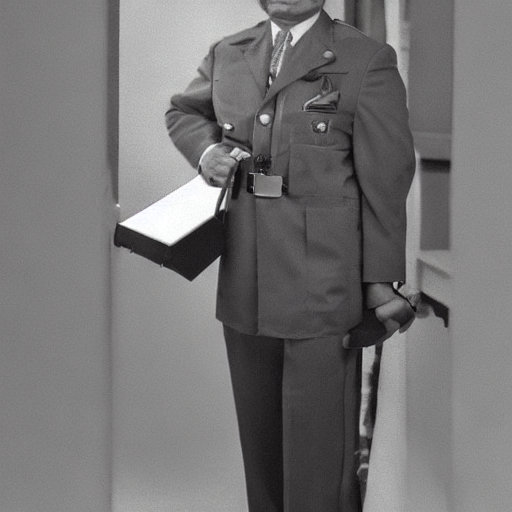

In [27]:
generator = torch.Generator(device).manual_seed(1024)

image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]

image

The other parameter in the pipeline call is `guidance_scale`. It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. In simple terms classifier free guidance forces the generation to better match with the prompt. Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse.

You can learn about the technical details of this parameter in [the last section](https://colab.research.google.com/drive/1ALXuCM5iNnJDNW5vqBm5lCtUQtZJHN2f?authuser=1#scrollTo=UZp-ynZLrS-S) of this notebook.



Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done.

General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's see how to make advanced use of 🤗 Hugging Face Diffusers!

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components.

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.